In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Analyst_Coverage.csv')
df.head()

,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
0,Jamrgett,3/5/2020,Beerg,5.0,buy,1.220000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
1,Joneeney,3/3/2020,Corch,3.0,equalweight,1.050000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
2,MarDeboo,3/2/2020,Jeies,3.0,hold,1.050000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
3,Niclberg,3/1/2020,Lirum,3.0,hold,1.070000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
4,Antpagna,2/27/2020,ISEVA,5.0,overweight,-2.420000e-14,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"


## Question 1
Which company has the higher analyst coverage?

Answer:
- `ADS GR Equity` has the highest coverage, with a total of 44 coverages in the data sample
- Average number of coverages per company is 24
- 3 companies have at most 3 coverages
- Distribution is not terribly askewed with similar mean and median

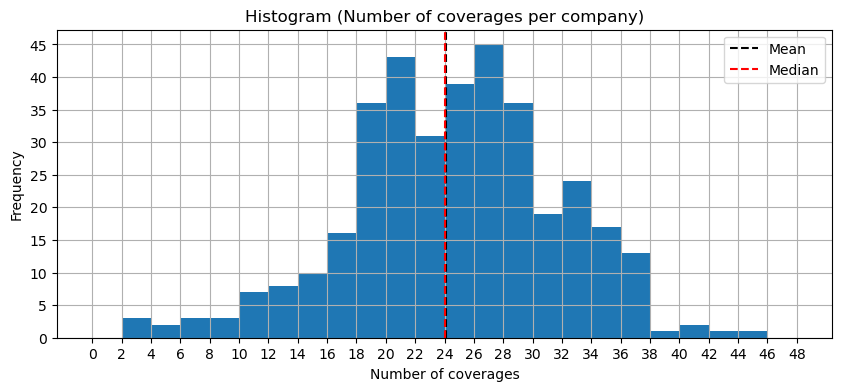

In [3]:
qn1 = df['BBTICKER'].value_counts()
bin_edges = np.arange(0,50,2)
qn1.hist(bins = bin_edges, figsize = (10,4))
plt.title('Histogram (Number of coverages per company)')
plt.xlabel('Number of coverages')
plt.ylabel('Frequency')
plt.xticks(np.arange(0,50,2))
plt.yticks(np.arange(0,50,5))
plt.axvline(qn1.mean(), ls = '--', c = 'k', label = 'Mean')
plt.axvline(qn1.median(), ls = '--', c = 'r', label = 'Median')
plt.legend()
plt.show()

In [4]:
qn1.head()

BBTICKER
ADS GR Equity     44
SAP GR Equity     42
ASML NA Equity    41
AZN LN Equity     40
MC FP Equity      38
Name: count, dtype: int64

---

## Question 2
Which analyst covers the most companies?
- Antpagna covers the most companies, total count = 206
- Majority of the analysts are specialists; 99.5% of the analysts cover no more than 17 companies
- Only two analysts had covered the same companies twice within the data sample


99.5 percentile: 17.0 coverages


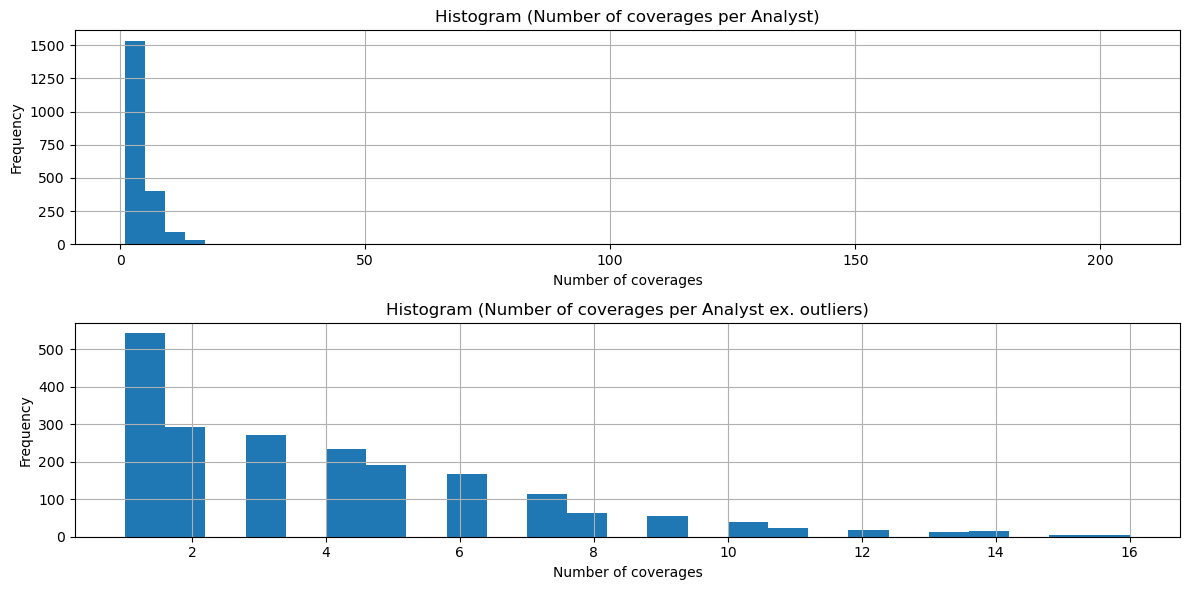

In [5]:
qn2a = df['ANALYST'].value_counts()
upper_limit = qn2a.quantile(0.995)
print(f'99.5 percentile: {upper_limit} coverages')
qn2b = qn2a[qn2a<qn2a.quantile(0.995)]

fig, axs = plt.subplots(2,1,figsize = (12,6))

qn2a.hist(bins = 50, ax = axs[0])
axs[0].set_title('Histogram (Number of coverages per Analyst)')
axs[0].set_xlabel('Number of coverages')
axs[0].set_ylabel('Frequency')

qn2b.hist(bins = 25, ax = axs[1])
axs[1].set_title('Histogram (Number of coverages per Analyst ex. outliers)')
axs[1].set_xlabel('Number of coverages')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
qn2a.head()

ANALYST
Antpagna    206
Valtaldy    162
Teaerage     44
Svemeier     38
Casy Lea     36
Name: count, dtype: int64

In [7]:
qn2c = df.groupby(by = ['ANALYST', 'BBTICKER'])['RATING'].value_counts()
qn2c[qn2c == qn2c.max()]

ANALYST   BBTICKER        RATING
JosOcina  GRF SM Equity   5.0       2
Teaerage  ALC SW Equity   3.0       2
          LOGN SW Equity  3.0       2
Name: count, dtype: int64

---

## Question 3
Based on how analysts organize themselves into covering companies,

### a. Could you model the similarity or conversely, the distance matrix between the companies based on this analyst co-coverage?

In this question, the following is explored
1. Running clustering algorithm with only analyst co-coverage as features
2. Running the same, with analyst co-coverage + brokerage firm as features
3. Analyst co-coverage + GICS sector classification as features
4. Analyst co-coverage + GICS industry classification as features
5. Analyst co-coverage + brokerage firm + GICS sector classification + GICS industry classification

We want to evaluate firstly, how well the clustering is with only analyst co-coverage, as the control. We will feed the algorithm with more information and monitor if the clustering improves.
The metrics used are Silhouette score and Davies-Bouldin score.

We run the above iterations for the following cases:
1. Full set of analyst co-coverage
2. Within 1sd from the mean of the analyst co-coverage
3. For a smaller subset (between 2 coverages - 14 coverages) which cover the entire 360 companies in scope

For each case, we will further analyse the clusters for the set of features that returns the best Silhouette score, and the optimal number of clusters it produced.

The best set of features is determined using the methodology as follows:
1. Reduce the high-dimensionality of the data into 2D using tSNE
2. Fit the reduced data into a K-mean clustering algorithm and optimize for the best number of cluster
3. With the optimized number of cluster, determine the Silhouette score and the Davies-Bouldin score.

We chose 'correlation' as the distance metric because we want to construct and analyse in a `covariance matrix`-like approach.

In [8]:
qn3ref =\
    df[['BBTICKER', 'GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']]\
        .value_counts()\
            .to_frame()\
                .reset_index()

qn3ref['NAME'] = qn3ref['BBTICKER'].apply(lambda x: x.rsplit(' ', 1)[0])
qn3ref.set_index('BBTICKER', inplace = True)
qn3ref.sort_index(inplace=True)
qn3ref['SECTOR_COLOR'] =\
    qn3ref['GICS_SECTOR_NAME']\
    .replace(
        {
            'Materials' : 'darksalmon',
            'Industrials' : 'tomato',
            'Consumer Staples' : 'steelblue',
            'Financials' : 'olivedrab',
            'Consumer Discretionary' : 'skyblue',
            'Information Technology' : 'darkorange',
            'Health Care' : 'salmon',
            'Real Estate' : 'rebeccapurple',
            'Energy' : 'yellowgreen',
            'Communication Services' : 'lemonchiffon',
            'Utilities' : 'chocolate'
        }
    )

qn3ref['INDUSTRY_COLOR'] =\
    qn3ref['GICS_INDUSTRY_GROUP_NAME']\
    .replace(
        {
            # Materials
            'Materials': 'darksalmon',
            # Industrial
            'Capital Goods': 'tomato',
            'Commercial & Professional Serv': 'salmon',
            'Transportation': 'orangered',
            # Consumer staples
            'Food & Staples Retailing': 'lightslategrey',
            'Food, Beverage & Tobacco': 'lightsteelblue',
            'Household & Personal Products': 'cadetblue',
            # Financials
            'Banks': 'mediumseagreen',
            'Insurance': 'yellowgreen',
            'Diversified Financials': 'forestgreen',
            # Consumer discretionary
            'Automobiles & Components': 'slateblue',
            'Consumer Durables & Apparel': 'mediumturquoise',
            'Consumer Services': 'powderblue',
            'Retailing': 'deepskyblue',
            # Information Technology
            'Software & Services': 'gold',
            'Technology Hardware & Equipmen': 'darkorange',
            'Semiconductors & Semiconductor': 'goldenrod',
            # Healthcare
            'Pharmaceuticals, Biotechnology': 'rosybrown',
            'Health Care Equipment & Servic': 'indianred',
            # Real estate
            'Real Estate': 'rebeccapurple',
            # Energy
            'Energy': 'yellowgreen',
            # Communication services
            'Telecommunication Services': 'lemonchiffon',
            'Media & Entertainment': 'cornsilk',
            # Utilities
            'Utilities': 'chocolate'
            }
    )
qn3ref.head()

,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME,count,NAME,SECTOR_COLOR,INDUSTRY_COLOR
BBTICKER,,,,,,
1COV GR Equity,Materials,Materials,28,1COV GR,darksalmon,darksalmon
AAL LN Equity,Materials,Materials,28,AAL LN,darksalmon,darksalmon
ABBN SW Equity,Industrials,Capital Goods,35,ABBN SW,tomato,tomato
ABF LN Equity,Consumer Staples,"Food, Beverage & Tobacco",26,ABF LN,steelblue,lightsteelblue
ABI BB Equity,Consumer Staples,"Food, Beverage & Tobacco",36,ABI BB,steelblue,lightsteelblue


In [9]:
qn3a_analyst =\
    pd.pivot_table(
        df[['BBTICKER', 'ANALYST']]
            .drop_duplicates()
            .value_counts().to_frame().reset_index(),
        index = 'BBTICKER',
        columns = 'ANALYST',
        values = 'count',
        aggfunc = 'count'
    )

qn3a_broker =\
    pd.pivot_table(
        df[['BBTICKER', 'BROKER']].value_counts().to_frame().reset_index(),
        index = 'BBTICKER',
        columns = 'BROKER',
        values = 'count',
        aggfunc = 'count'
    )

qn3a_IndGrpName =\
    pd.pivot_table(
        df[['BBTICKER', 'GICS_INDUSTRY_GROUP_NAME']].value_counts().to_frame().reset_index(),
        index = 'BBTICKER',
        columns = 'GICS_INDUSTRY_GROUP_NAME',
        values = 'count',
        aggfunc = 'count'
    )

qn3a_SectorName =\
    pd.pivot_table(
        df[['BBTICKER', 'GICS_SECTOR_NAME']].value_counts().to_frame().reset_index(),
        index = 'BBTICKER',
        columns = 'GICS_SECTOR_NAME',
        values = 'count',
        aggfunc = 'count'
    )


qn3a_analyst.fillna(0,inplace = True)
qn3a_broker.fillna(0,inplace = True)
qn3a_IndGrpName.fillna(0,inplace = True)
qn3a_SectorName.fillna(0,inplace = True)

In [10]:
class CustomCompanyClassification:
    """
    A class used for custom company classification based on various metrics and clustering techniques.

    Attributes:
        matrix (pd.DataFrame | np.ndarray): The input matrix containing data.
        ref (pd.DataFrame): The reference DataFrame.
        __name__ (str): The name of the classification, if provided.

    Methods:
        get_distance_matrix(metric, save=True):
            Computes the distance matrix using the specified metric.

        perform_tSNE(dist_matrix=None, save=True, seed=632):
            Performs t-SNE dimensionality reduction on the distance matrix.

        define_cluster_scores(k, X_embedded=None, seed=632, save=True):
            Defines clustering scores including silhouette and Davies-Bouldin scores.

        determine_optimal_clusters(k_min=2, k_max=20, X_embedded=None, seed=632):
            Determines the optimal number of clusters using the elbow method.

        plot_cluster(ax=None, shading='SECTOR'):
            Plots the clusters with optional shading by sector or industry.
    """
    def __init__(self,
                 input_matrix: pd.DataFrame | np.ndarray,
                 reference : pd.DataFrame,
                 name : str = None):
        """
        Initializes the CustomCompanyClassification class with input data and reference information.

        Args:
            input_matrix (pd.DataFrame | np.ndarray): The input data matrix.
            reference (pd.DataFrame): The reference DataFrame.
            name (str, optional): The name for the classification instance. Defaults to None.
        """

        self.matrix = input_matrix
        self.ref = reference
        if name:
            self.__name__ = name

    def get_distance_matrix(self,
                            metric : str,
                            save : bool = True):
        """
        Computes the distance matrix using the specified metric.

        Args:
            metric (str): The distance metric to use.
            save (bool, optional): Whether to save the distance matrix to the instance. Defaults to True.

        Returns:
            np.ndarray: The distance matrix if `save` is False.
        """

        dist_matrix =\
            squareform(pdist(self.matrix, metric=metric))

        if save:
            self.dist_matrix = dist_matrix
        else:
            return dist_matrix

    def perform_tSNE(self,
                     dist_matrix : np.ndarray | pd.DataFrame = None,
                     save : bool = True,
                     seed : int = 632):
        """
        Performs t-SNE dimensionality reduction on the distance matrix.

        Args:
            dist_matrix (np.ndarray | pd.DataFrame, optional): The distance matrix to use. Defaults to None.
            save (bool, optional): Whether to save the embedded coordinates to the instance. Defaults to True.
            seed (int, optional): The random seed for t-SNE. Defaults to 632.

        Returns:
            np.ndarray: The embedded coordinates if `save` is False.
        """

        tsne = TSNE(n_components=2, random_state = seed)
        if not dist_matrix:
            dist_matrix = self.dist_matrix

        X_embedded = tsne.fit_transform(dist_matrix)

        if save:
            self.X_embedded = X_embedded
        else:
            return X_embedded

    def define_cluster_scores(self,
                       k : int,
                       X_embedded : np.ndarray = None,
                       seed : int = 632,
                       save : bool = True):
        """
        Defines clustering scores including silhouette and Davies-Bouldin scores.

        Args:
            k (int): The number of clusters.
            X_embedded (np.ndarray, optional): The embedded coordinates. Defaults to None.
            seed (int, optional): The random seed for KMeans. Defaults to 632.
            save (bool, optional): Whether to save the clustering results to the instance. Defaults to True.

        Returns:
            tuple: The cluster labels, average silhouette score, and Davies-Bouldin score if `save` is False.
        """

        if not X_embedded:
            X_embedded = self.X_embedded

        kmeans = KMeans(n_clusters=k, random_state=seed)
        labels = kmeans.fit_predict(X_embedded)

        avg_silhouette_score = silhouette_score(X_embedded, labels, metric='euclidean')
        db_score = davies_bouldin_score(X_embedded, labels)

        if save:
            self.cluster_labels = labels
            self.silhouette_score = avg_silhouette_score
            self.db_score = db_score
        else:
            return labels, avg_silhouette_score, db_score


    def determine_optimal_clusters(self,
                                   k_min : int = 2,
                                   k_max : int = 20,
                                   X_embedded : np.ndarray = None,
                                   seed : int = 632):
        """
        Determines the optimal number of clusters using the elbow method.

        Args:
            k_min (int, optional): The minimum number of clusters to test. Defaults to 2.
            k_max (int, optional): The maximum number of clusters to test. Defaults to 20.
            X_embedded (np.ndarray, optional): The embedded coordinates. Defaults to None.
            seed (int, optional): The random seed for KMeans. Defaults to 632.

        Returns:
            dict: A dictionary containing the sum of squared distances, the elbow point, and the optimal number of clusters.
        """

        if not X_embedded:
            X_embedded = self.X_embedded

        sum_squared_distances = []

        for k in range(k_min, k_max+1):
            model = KMeans(n_clusters=k, random_state=seed)
            model = model.fit(X_embedded)
            #calculate sum of squared distances of each observation to its own cluster's centroid
            sum_squared_distances.append(model.inertia_)

        diff = np.diff(sum_squared_distances)
        diff2 = np.diff(diff)

        # Find the elbow point
        elbow_point = np.argwhere(diff2 == np.min(diff2)).flatten()[0] + 2

        return {
            'sum_squared_dist' : sum_squared_distances,
            'elbow_point' : elbow_point,
            'optimal_k' : list(range(k_min, k_max+1))[elbow_point]
        }

    def plot_cluster(self, ax = None, shading = 'SECTOR'):
        """
        Plots the clusters with optional shading by sector or industry.

        Args:
            ax (matplotlib.axes._axes.Axes, optional): The axes to plot on. Defaults to None.
            shading (str, optional): The shading scheme to use. Must be 'SECTOR' or 'INDUSTRY'. Defaults to 'SECTOR'.

        Raises:
            AssertionError: If an unsupported shading scheme is provided.
        """

        assert shading in ['SECTOR', 'INDUSTRY'], f"Unsupported shading scheme! Provided: {shading}."
        if not ax:
            plt.figure(figsize=(8, 6))
            ax = plt.axes()

        ax.scatter(self.X_embedded[:, 0], self.X_embedded[:, 1], c=qn3ref['SECTOR_COLOR'])

        for i, label in enumerate(self.ref['NAME']):
            ax.annotate(
                label,
                (self.X_embedded[i, 0], self.X_embedded[i, 1]),
                textcoords="offset points",  # How to position the text
                xytext=(1,1),                # Distance from the point (x,y)
                ha='center',                 # Horizontal alignment
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor=qn3ref.iloc[i][f'{shading}_COLOR']),
                fontsize = 'xx-small'
            )

        ax.set_title(self.__name__ + f"\nShade: {shading}")



In [11]:
# Create additional features to pair with analyst co-coverage
qn3a1 = pd.concat([qn3a_analyst, qn3a_broker], axis=1) # analyst co-coverage + broker
qn3a2 = pd.concat([qn3a_analyst, qn3a_SectorName], axis=1) # analyst co-coverage + GICS Sector classification
qn3a3 = pd.concat([qn3a_analyst, qn3a_IndGrpName], axis=1) # analyst co-coverage + GICS IND classification
qn3a4 = pd.concat([qn3a_analyst, qn3a_SectorName, qn3a_IndGrpName, qn3a_broker], axis=1) # ALL

print(f'There are in total {qn3a_analyst.shape[1]:,} observations in the data sample.')

There are in total 2,065 observations in the data sample.


In [12]:
# Run clustering based on analyst co-coverage only
cluster_3a0 = CustomCompanyClassification(qn3a_analyst, qn3ref, name = "Custom company classification\n Analyst co-coverage only")
cluster_3a0.get_distance_matrix(metric = 'correlation')
cluster_3a0.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3a1 = CustomCompanyClassification(qn3a1, qn3ref, name = "Custom company classification\n Analyst co-coverage + brokerage firm")
cluster_3a1.get_distance_matrix(metric = 'correlation')
cluster_3a1.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3a2 = CustomCompanyClassification(qn3a2, qn3ref, name = "Custom company classification\n Analyst co-coverage + GICS Sector classification")
cluster_3a2.get_distance_matrix(metric = 'correlation')
cluster_3a2.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3a3 = CustomCompanyClassification(qn3a3, qn3ref, name = "Custom company classification\n Analyst co-coverage + GICS Industry classification")
cluster_3a3.get_distance_matrix(metric = 'correlation')
cluster_3a3.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3a4 = CustomCompanyClassification(qn3a4, qn3ref, name = "Custom company classification\n Analyst co-coverage + All")
cluster_3a4.get_distance_matrix(metric = 'correlation')
cluster_3a4.perform_tSNE()

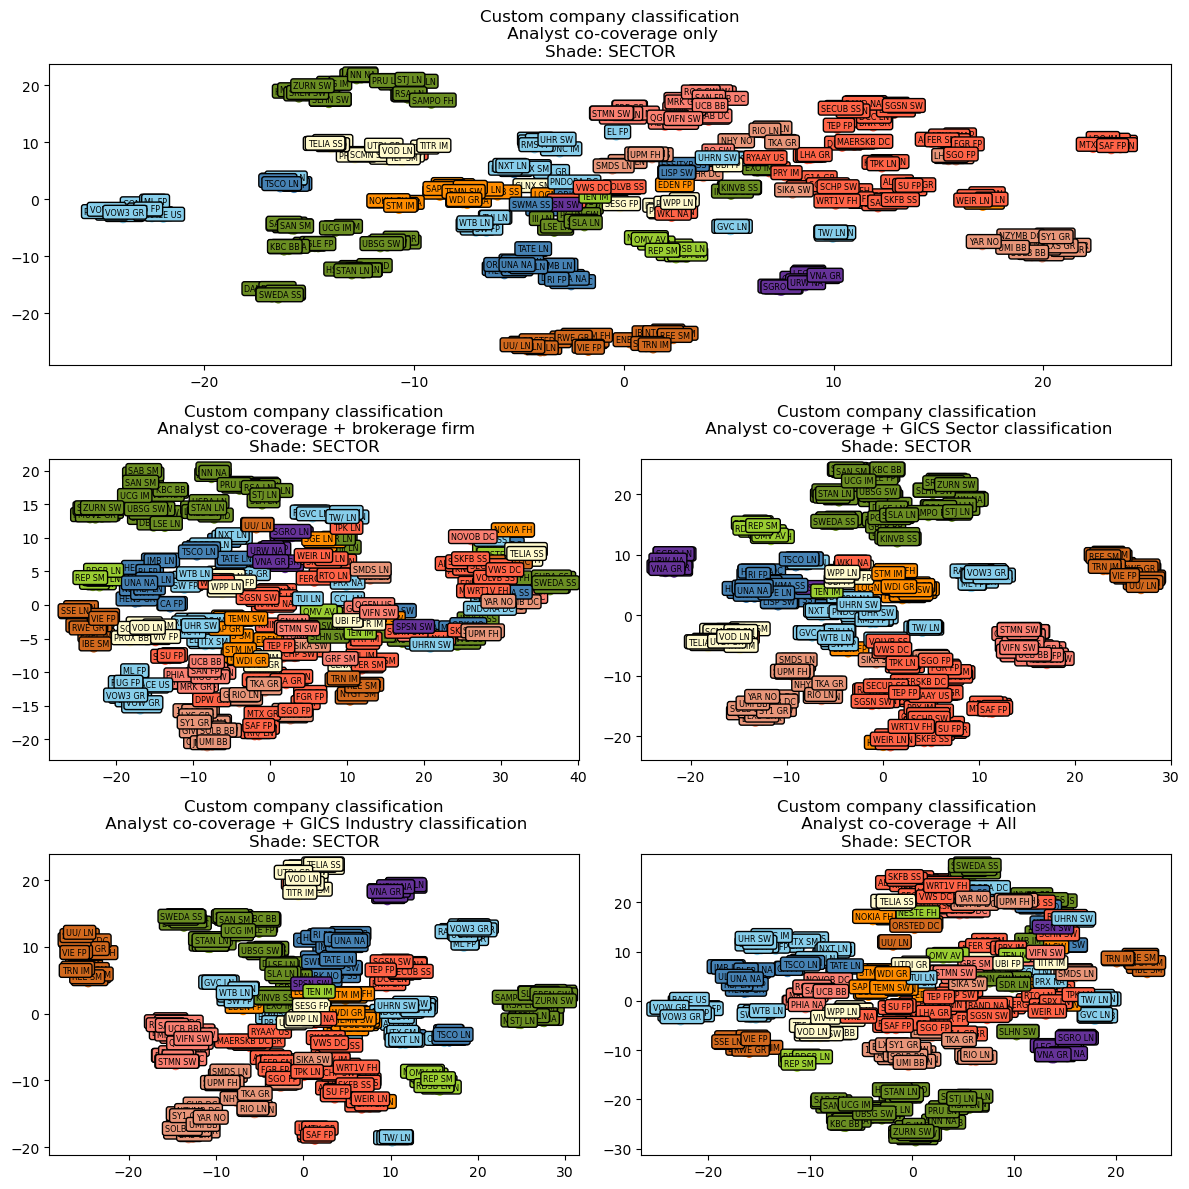

In [13]:
# Plot clusters
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0, :])
cluster_3a0.plot_cluster(ax = ax0)
ax1 = plt.subplot(gs[1, 0])
cluster_3a1.plot_cluster(ax = ax1)
ax2 = plt.subplot(gs[1, 1])
cluster_3a2.plot_cluster(ax = ax2)
ax3 = plt.subplot(gs[2, 0])
cluster_3a3.plot_cluster(ax = ax3)
ax4 = plt.subplot(gs[2, 1])
cluster_3a4.plot_cluster(ax = ax4)
plt.tight_layout()
plt.show()

In [40]:
cluster_3a0.get_distance_matrix(metric="correlation", save = False).shape

(360, 360)

In [14]:
res3a0 = cluster_3a0.determine_optimal_clusters()
cluster_3a0.define_cluster_scores(res3a0['optimal_k'])
print(f'Analyst-only matrix: Silhouette score = {cluster_3a0.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3a0.db_score:.3f}')

res3a1 = cluster_3a1.determine_optimal_clusters()
cluster_3a1.define_cluster_scores(res3a1['optimal_k'])
print(f'Analyst-brokerage matrix: Silhouette score = {cluster_3a1.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3a1.db_score:.3f}')

res3a2 = cluster_3a2.determine_optimal_clusters()
cluster_3a2.define_cluster_scores(res3a2['optimal_k'])
print(f'Analyst-Sectorname matrix: Silhouette score = {cluster_3a2.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3a2.db_score:.3f}')

res3a3 = cluster_3a3.determine_optimal_clusters()
cluster_3a3.define_cluster_scores(res3a3['optimal_k'])
print(f'Analyst-IndustryGroupName: Silhouette score = {cluster_3a3.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3a3.db_score:.3f}')

res3a4 = cluster_3a4.determine_optimal_clusters()
cluster_3a4.define_cluster_scores(res3a4['optimal_k'])
print(f'Full matrix: Silhouette score = {cluster_3a4.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3a4.db_score:.3f}')

Analyst-only matrix: Silhouette score = 0.551, Davies-Bouldin score = 0.601
Analyst-brokerage matrix: Silhouette score = 0.438, Davies-Bouldin score = 0.741
Analyst-Sectorname matrix: Silhouette score = 0.542, Davies-Bouldin score = 0.637
Analyst-IndustryGroupName: Silhouette score = 0.579, Davies-Bouldin score = 0.597
Full matrix: Silhouette score = 0.426, Davies-Bouldin score = 0.778


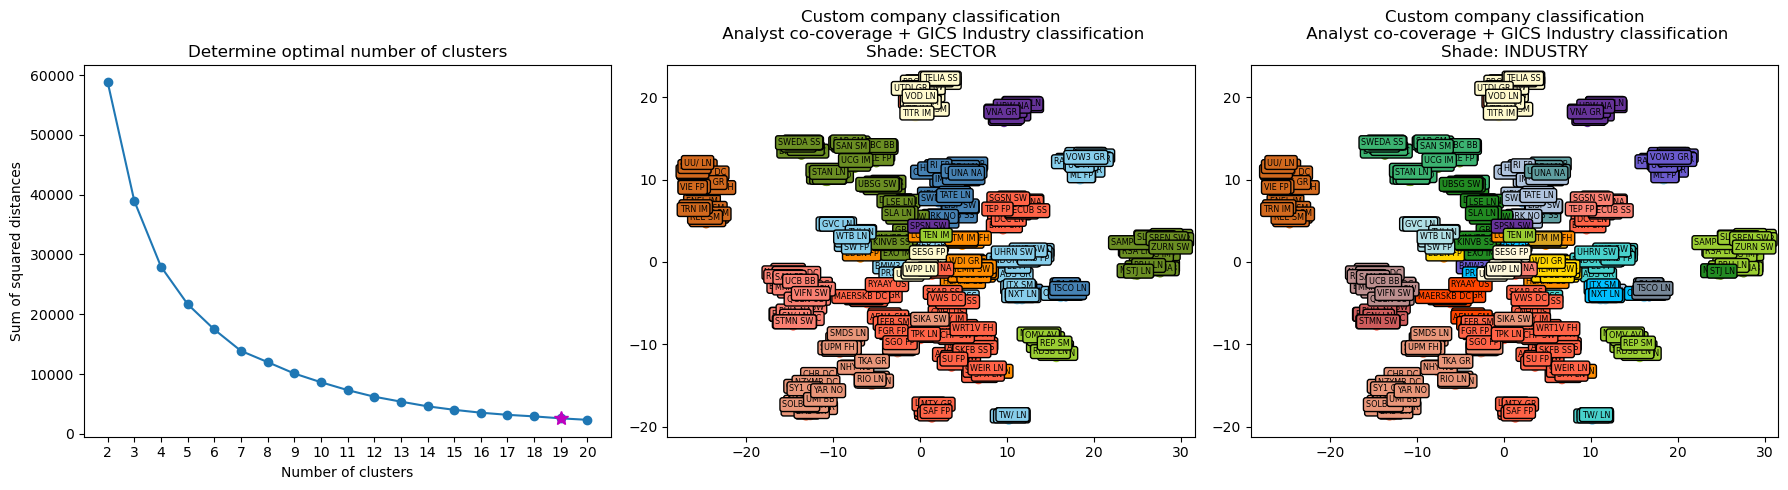

In [15]:
fig, axs = plt.subplots(1,3, figsize = (18,5))
x = range(2, 21)
y = res3a3['sum_squared_dist']
x0 = res3a3['optimal_k']
y0 = y[res3a3['elbow_point']]
axs[0].plot(x, y, marker='o')
axs[0].plot(x0, y0, '-m*', markersize = 10, label='Optimal number of clusters')
axs[0].set_xticks(x)
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Sum of squared distances')
axs[0].set_title('Determine optimal number of clusters')

cluster_3a3.plot_cluster(ax = axs[1])
cluster_3a3.plot_cluster(ax = axs[2], shading='INDUSTRY')

plt.tight_layout()
plt.show()

### b.How would the results change if you were to restrict the dataset to only analysts having companies covered within 1s.d. of the distribution found in Qn. 2?

In [16]:
lower_limit = max(qn2a.mean() - qn2a.std(), 0)

In [17]:
lower_limit

0

In [18]:
upper_limit = qn2a.mean() + qn2a.std()
lower_limit = max(qn2a.mean() - qn2a.std(), 0)
analysts_in_scope_b = qn2a[qn2a.between(lower_limit, upper_limit)].index

qn3b_prep = df.loc[df['ANALYST'].isin(analysts_in_scope_b), ['ANALYST', 'BBTICKER']]

qn3b_analyst =\
    pd.pivot_table(
        qn3b_prep[['BBTICKER', 'ANALYST']]
            .drop_duplicates().value_counts().to_frame().reset_index(),
        index = 'BBTICKER',
        columns = 'ANALYST',
        values = 'count',
        aggfunc = 'count'
    )
qn3b_analyst.fillna(0,inplace = True)

qn3b1 = pd.concat([qn3b_analyst, qn3a_broker], axis=1)
qn3b2 = pd.concat([qn3b_analyst, qn3a_SectorName], axis=1)
qn3b3 = pd.concat([qn3b_analyst, qn3a_IndGrpName], axis=1)
qn3b4 = pd.concat([qn3b_analyst, qn3a_SectorName, qn3a_IndGrpName, qn3a_broker], axis=1)

print(f'There are in total {qn3b_analyst.shape[1]:,} observations in the data sample, after restricting the samples to within 1 s.d.')

There are in total 1,974 observations in the data sample, after restricting the samples to within 1 s.d.


In [19]:
# Run clustering based on analyst co-coverage only
cluster_3b0 = CustomCompanyClassification(qn3b_analyst, qn3ref, name = "Custom company classification\n Analyst co-coverage only")
cluster_3b0.get_distance_matrix(metric = 'correlation')
cluster_3b0.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3b1 = CustomCompanyClassification(qn3b1, qn3ref, name = "Custom company classification\n Analyst co-coverage + brokerage firm")
cluster_3b1.get_distance_matrix(metric = 'correlation')
cluster_3b1.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3b2 = CustomCompanyClassification(qn3b2, qn3ref, name = "Custom company classification\n Analyst co-coverage + GICS Sector classification")
cluster_3b2.get_distance_matrix(metric = 'correlation')
cluster_3b2.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3b3 = CustomCompanyClassification(qn3b3, qn3ref, name = "Custom company classification\n Analyst co-coverage + GICS Industry classification")
cluster_3b3.get_distance_matrix(metric = 'correlation')
cluster_3b3.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3b4 = CustomCompanyClassification(qn3b4, qn3ref, name = "Custom company classification\n Analyst co-coverage + All")
cluster_3b4.get_distance_matrix(metric = 'correlation')
cluster_3b4.perform_tSNE()

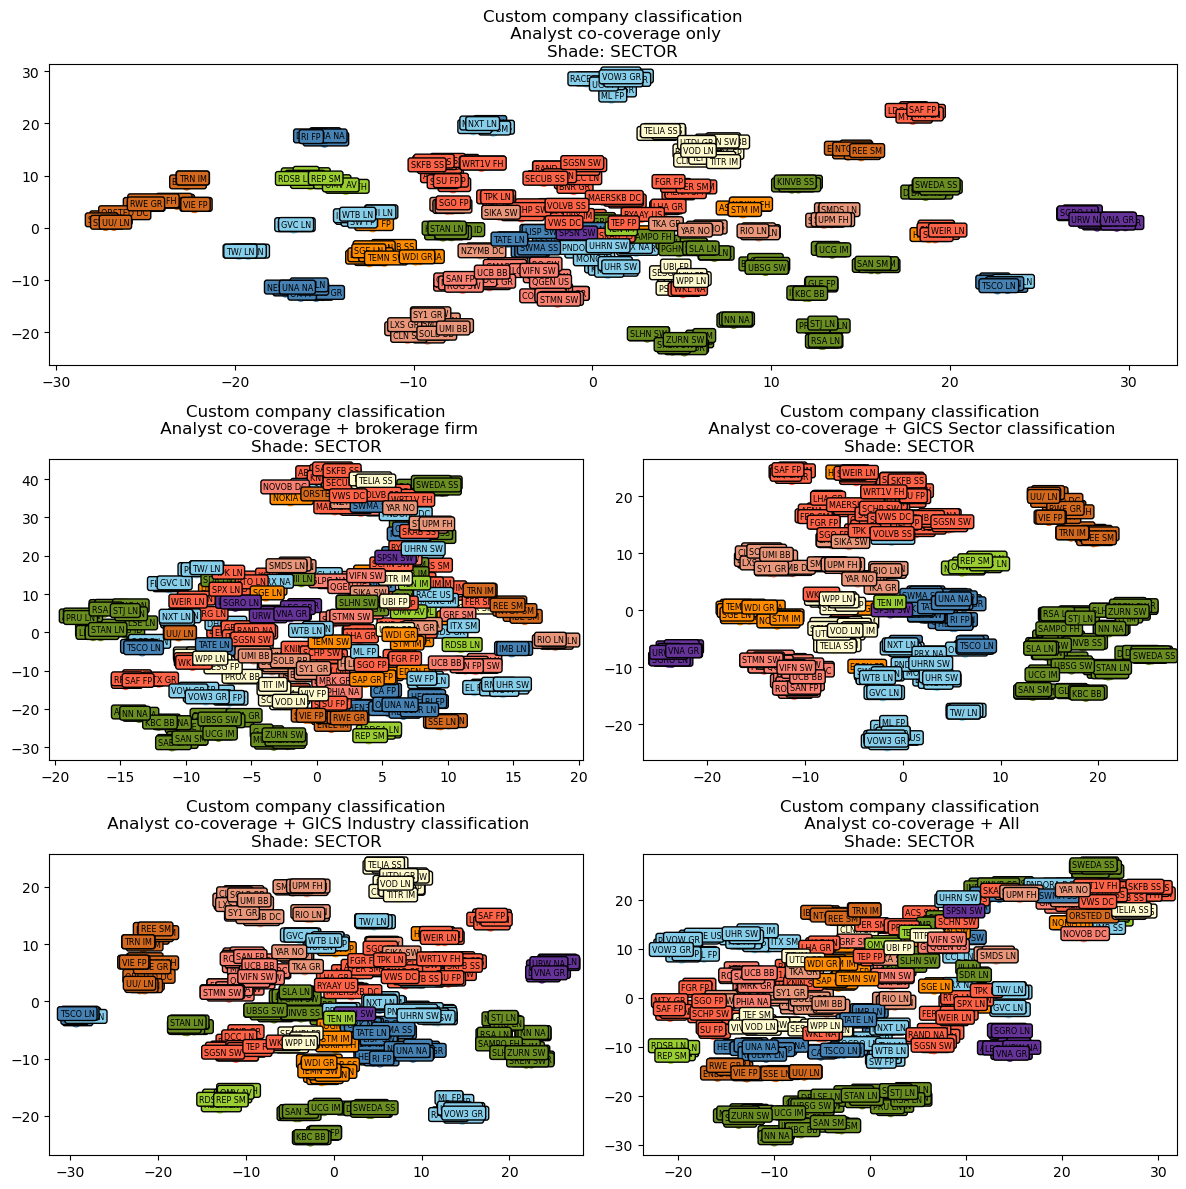

In [20]:
# Plot clusters
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0, :])
cluster_3b0.plot_cluster(ax = ax0)
ax1 = plt.subplot(gs[1, 0])
cluster_3b1.plot_cluster(ax = ax1)
ax2 = plt.subplot(gs[1, 1])
cluster_3b2.plot_cluster(ax = ax2)
ax3 = plt.subplot(gs[2, 0])
cluster_3b3.plot_cluster(ax = ax3)
ax4 = plt.subplot(gs[2, 1])
cluster_3b4.plot_cluster(ax = ax4)
plt.tight_layout()
plt.show()

In [21]:
res3b0 = cluster_3b0.determine_optimal_clusters()
cluster_3b0.define_cluster_scores(res3b0['optimal_k'])
print(f'Analyst-only matrix: Silhouette score = {cluster_3b0.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3b0.db_score:.3f}')

res3b1 = cluster_3b1.determine_optimal_clusters()
cluster_3b1.define_cluster_scores(res3b1['optimal_k'])
print(f'Analyst-brokerage matrix: Silhouette score = {cluster_3b1.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3b1.db_score:.3f}')

res3b2 = cluster_3b2.determine_optimal_clusters()
cluster_3b2.define_cluster_scores(res3b2['optimal_k'])
print(f'Analyst-Sectorname matrix: Silhouette score = {cluster_3b2.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3b2.db_score:.3f}')

res3b3 = cluster_3b3.determine_optimal_clusters()
cluster_3b3.define_cluster_scores(res3b3['optimal_k'])
print(f'Analyst-IndustryGroupName: Silhouette score = {cluster_3b3.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3b3.db_score:.3f}')

res3b4 = cluster_3b4.determine_optimal_clusters()
cluster_3b4.define_cluster_scores(res3b4['optimal_k'])
print(f'Full matrix: Silhouette score = {cluster_3b4.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3b4.db_score:.3f}')

Analyst-only matrix: Silhouette score = 0.456, Davies-Bouldin score = 0.723
Analyst-brokerage matrix: Silhouette score = 0.416, Davies-Bouldin score = 0.760
Analyst-Sectorname matrix: Silhouette score = 0.505, Davies-Bouldin score = 0.675
Analyst-IndustryGroupName: Silhouette score = 0.461, Davies-Bouldin score = 0.671
Full matrix: Silhouette score = 0.439, Davies-Bouldin score = 0.745


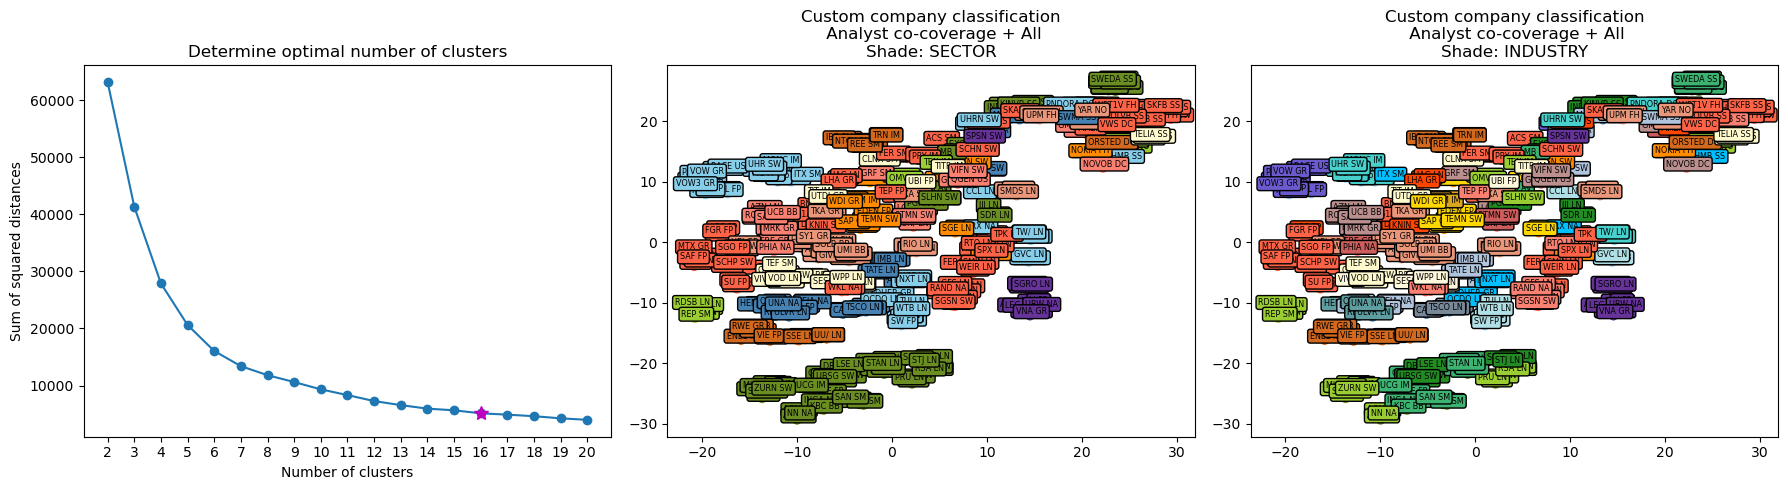

In [22]:
fig, axs = plt.subplots(1,3, figsize = (18,5))
x = range(2, 21)
y = res3b4['sum_squared_dist']
x0 = res3b4['optimal_k']
y0 = y[res3b4['elbow_point']]
axs[0].plot(x, y, marker='o')
axs[0].plot(x0, y0, '-m*', markersize = 10, label='Optimal number of clusters')
axs[0].set_xticks(x)
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Sum of squared distances')
axs[0].set_title('Determine optimal number of clusters')

cluster_3b4.plot_cluster(ax = axs[1])
cluster_3b4.plot_cluster(ax = axs[2], shading='INDUSTRY')

plt.tight_layout()
plt.show()

### c) If further restricted to a smaller subset: 2-14

In [23]:
upper_limit = 14
lower_limit = 2
analysts_in_scope_c = qn2a[qn2a.between(lower_limit, upper_limit)].index

qn3c_prep = df.loc[df['ANALYST'].isin(analysts_in_scope_c), ['ANALYST', 'BBTICKER']]
print(qn3c_prep.shape, qn3c_prep['BBTICKER'].unique().shape)

(7302, 2) (360,)


In [24]:
qn3c_analyst =\
    pd.pivot_table(
        qn3c_prep[['BBTICKER', 'ANALYST']].value_counts().to_frame().reset_index(),
        index = 'BBTICKER',
        columns = 'ANALYST',
        values = 'count',
        aggfunc = 'count'
    )

qn3c_analyst.fillna(0,inplace = True)
qn3c1 = pd.concat([qn3c_analyst, qn3a_broker], axis=1)
qn3c2 = pd.concat([qn3c_analyst, qn3a_SectorName], axis=1)
qn3c3 = pd.concat([qn3c_analyst, qn3a_IndGrpName], axis=1)
qn3c4 = pd.concat([qn3c_analyst, qn3a_SectorName, qn3a_IndGrpName, qn3a_broker], axis=1)

print(f'There are in total {qn3c_analyst.shape[1]:,} observations in the data sample, after further restricting the sample.')
print('This is the smallest possible sample which covers all 360 companies, while not skipping any observation in between.')

There are in total 1,496 observations in the data sample, after further restricting the sample.
This is the smallest possible sample which covers all 360 companies, while not skipping any observation in between.


In [25]:
# Run clustering based on analyst co-coverage only
cluster_3c0 = CustomCompanyClassification(qn3c_analyst, qn3ref, name = "Custom company classification\n Analyst co-coverage only")
cluster_3c0.get_distance_matrix(metric = 'correlation')
cluster_3c0.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3c1 = CustomCompanyClassification(qn3c1, qn3ref, name = "Custom company classification\n Analyst co-coverage + brokerage firm")
cluster_3c1.get_distance_matrix(metric = 'correlation')
cluster_3c1.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3c2 = CustomCompanyClassification(qn3c2, qn3ref, name = "Custom company classification\n Analyst co-coverage + GICS Sector classification")
cluster_3c2.get_distance_matrix(metric = 'correlation')
cluster_3c2.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3c3 = CustomCompanyClassification(qn3c3, qn3ref, name = "Custom company classification\n Analyst co-coverage + GICS Industry classification")
cluster_3c3.get_distance_matrix(metric = 'correlation')
cluster_3c3.perform_tSNE()

# Run clustering based on analyst co-coverage + brokerage firm only
cluster_3c4 = CustomCompanyClassification(qn3c4, qn3ref, name = "Custom company classification\n Analyst co-coverage + All")
cluster_3c4.get_distance_matrix(metric = 'correlation')
cluster_3c4.perform_tSNE()

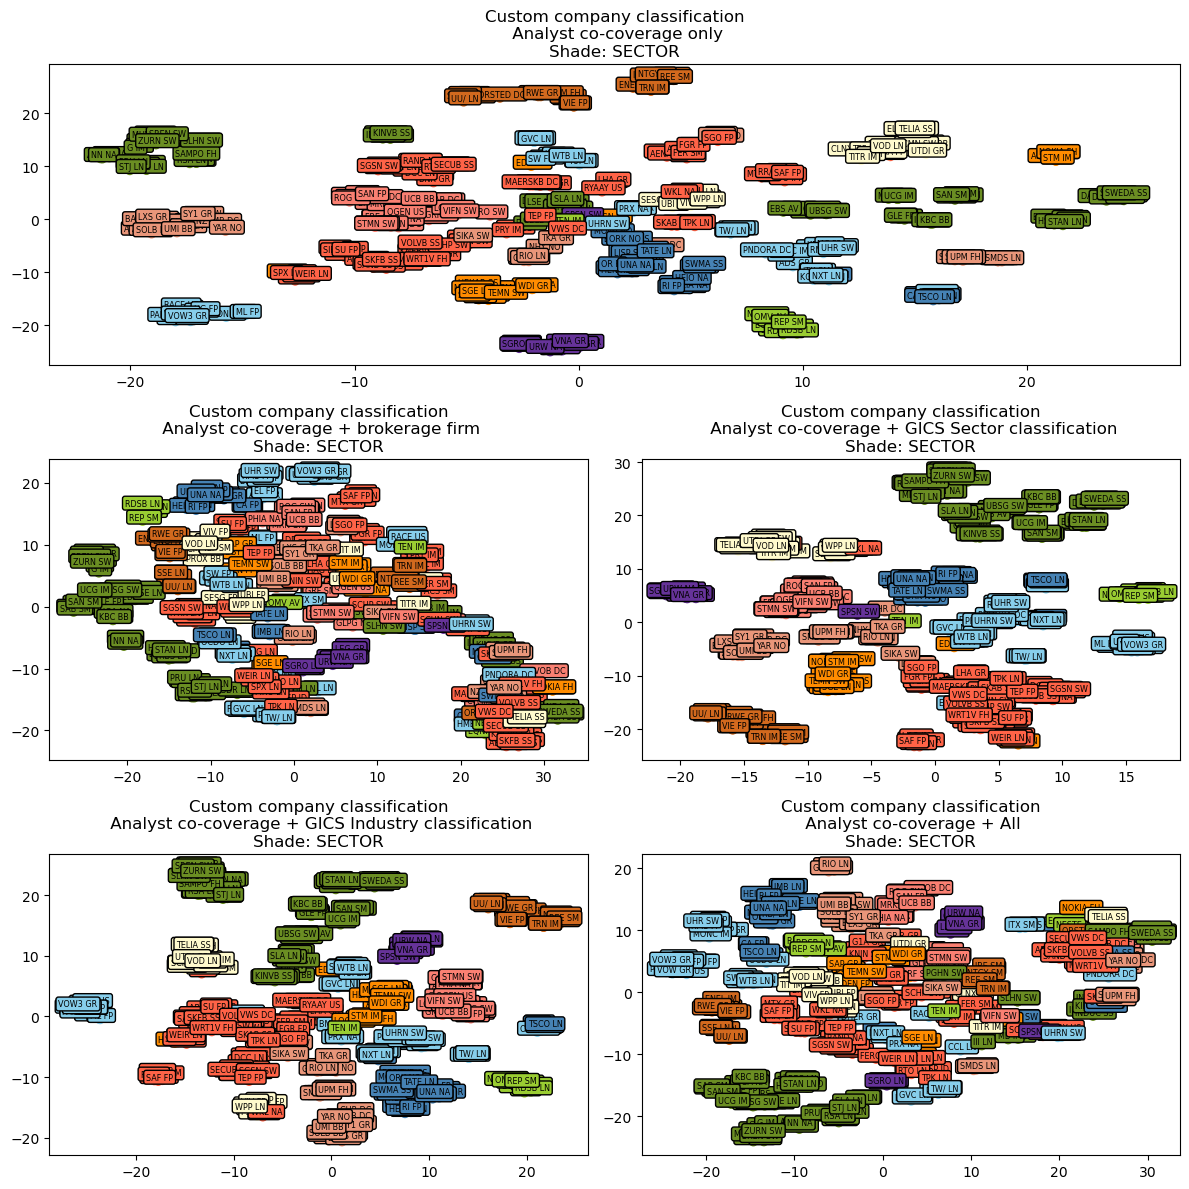

In [26]:
# Plot clusters
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0, :])
cluster_3c0.plot_cluster(ax = ax0)
ax1 = plt.subplot(gs[1, 0])
cluster_3c1.plot_cluster(ax = ax1)
ax2 = plt.subplot(gs[1, 1])
cluster_3c2.plot_cluster(ax = ax2)
ax3 = plt.subplot(gs[2, 0])
cluster_3c3.plot_cluster(ax = ax3)
ax4 = plt.subplot(gs[2, 1])
cluster_3c4.plot_cluster(ax = ax4)
plt.tight_layout()
plt.show()

In [27]:
res3c0 = cluster_3c0.determine_optimal_clusters()
cluster_3c0.define_cluster_scores(res3c0['optimal_k'])
print(f'Analyst-only matrix: Silhouette score = {cluster_3c0.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3c0.db_score:.3f}')

res3c1 = cluster_3c1.determine_optimal_clusters()
cluster_3c1.define_cluster_scores(res3c1['optimal_k'])
print(f'Analyst-brokerage matrix: Silhouette score = {cluster_3c1.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3c1.db_score:.3f}')

res3c2 = cluster_3c2.determine_optimal_clusters()
cluster_3c2.define_cluster_scores(res3c2['optimal_k'])
print(f'Analyst-Sectorname matrix: Silhouette score = {cluster_3c2.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3c2.db_score:.3f}')

res3c3 = cluster_3c3.determine_optimal_clusters()
cluster_3c3.define_cluster_scores(res3c3['optimal_k'])
print(f'Analyst-IndustryGroupName: Silhouette score = {cluster_3c3.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3c3.db_score:.3f}')

res3c4 = cluster_3c4.determine_optimal_clusters()
cluster_3c4.define_cluster_scores(res3c4['optimal_k'])
print(f'Full matrix: Silhouette score = {cluster_3c4.silhouette_score:.3f}, Davies-Bouldin score = {cluster_3c4.db_score:.3f}')

Analyst-only matrix: Silhouette score = 0.480, Davies-Bouldin score = 0.654
Analyst-brokerage matrix: Silhouette score = 0.421, Davies-Bouldin score = 0.752
Analyst-Sectorname matrix: Silhouette score = 0.460, Davies-Bouldin score = 0.799
Analyst-IndustryGroupName: Silhouette score = 0.567, Davies-Bouldin score = 0.589
Full matrix: Silhouette score = 0.400, Davies-Bouldin score = 0.813


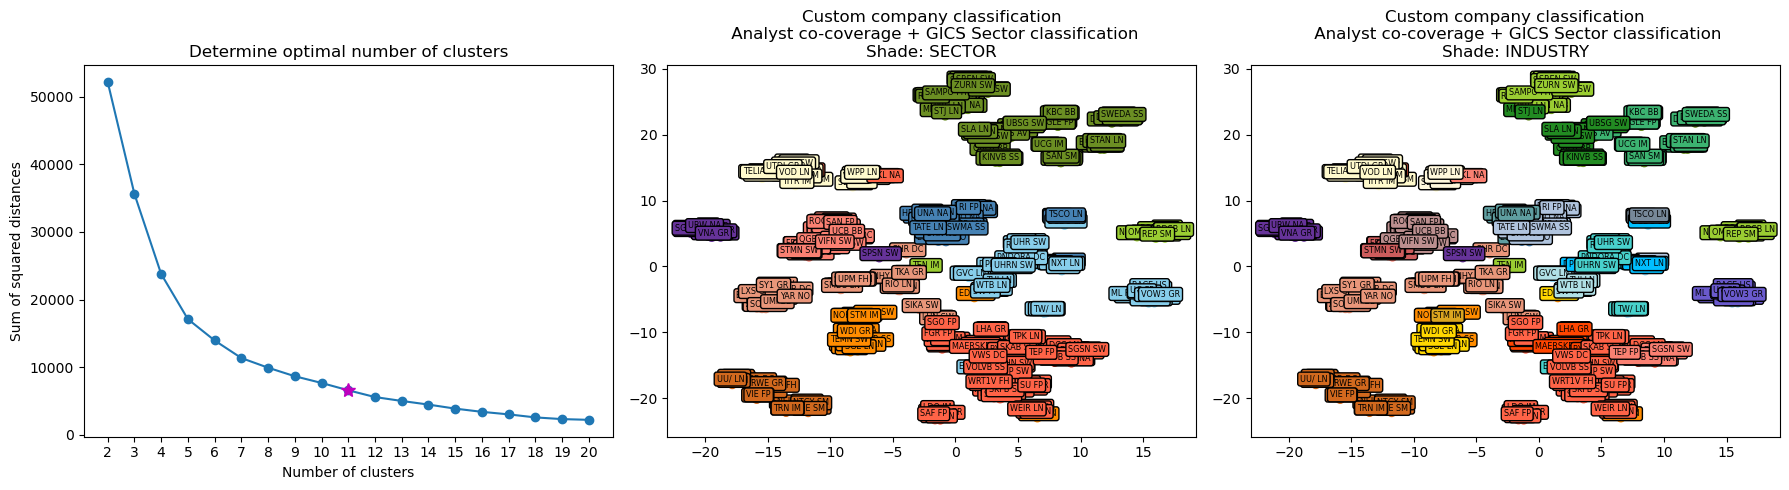

In [28]:
fig, axs = plt.subplots(1,3, figsize = (18,5))
x = range(2, 21)
y = res3c2['sum_squared_dist']
x0 = res3c2['optimal_k']
y0 = y[res3c2['elbow_point']]
axs[0].plot(x, y, marker='o')
axs[0].plot(x0, y0, '-m*', markersize = 10, label='Optimal number of clusters')
axs[0].set_xticks(x)
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Sum of squared distances')
axs[0].set_title('Determine optimal number of clusters')

cluster_3c2.plot_cluster(ax = axs[1])
cluster_3c2.plot_cluster(ax = axs[2], shading='INDUSTRY')

plt.tight_layout()
plt.show()

---

In [29]:
series_3a =\
    pd.Series(
        data = [cluster_3a0.silhouette_score,
                cluster_3a1.silhouette_score,
                cluster_3a2.silhouette_score,
                cluster_3a3.silhouette_score,
                cluster_3a4.silhouette_score],
         index = ['analyst', 'analyst+broker', 'analyst+sector_name', 'analyst+industry_grp_name', 'full matrix'],
         name = 'all-range')

series_3b =\
    pd.Series(
        data = [cluster_3b0.silhouette_score,
                cluster_3b1.silhouette_score,
                cluster_3b2.silhouette_score,
                cluster_3b3.silhouette_score,
                cluster_3b4.silhouette_score],
         index = ['analyst', 'analyst+broker', 'analyst+sector_name', 'analyst+industry_grp_name', 'full matrix'],
         name = 'within 1s.d.')

series_3c =\
    pd.Series(
        data = [cluster_3c0.silhouette_score,
                cluster_3c1.silhouette_score,
                cluster_3c2.silhouette_score,
                cluster_3c3.silhouette_score,
                cluster_3c4.silhouette_score],
         index = ['analyst', 'analyst+broker', 'analyst+sector_name', 'analyst+industry_grp_name', 'full matrix'],
         name = 'smaller subset')

sihouette_score_df = pd.concat([series_3a, series_3b, series_3c], axis=1)
sihouette_score_df

,all-range,within 1s.d.,smaller subset
analyst,0.551347,0.455632,0.479596
analyst+broker,0.437606,0.416024,0.421030
analyst+sector_name,0.542014,0.505257,0.459635
analyst+industry_grp_name,0.579313,0.461344,0.567274
full matrix,0.425691,0.438793,0.400346


In [30]:
dbseries_3a =\
    pd.Series(
        data = [cluster_3a0.db_score,
                cluster_3a1.db_score,
                cluster_3a2.db_score,
                cluster_3a3.db_score,
                cluster_3a4.db_score],
         index = ['analyst', 'analyst+broker', 'analyst+sector_name', 'analyst+industry_grp_name', 'full matrix'],
         name = 'all-range')

dbseries_3b =\
    pd.Series(
        data = [cluster_3b0.db_score,
                cluster_3b1.db_score,
                cluster_3b2.db_score,
                cluster_3b3.db_score,
                cluster_3b4.db_score],
         index = ['analyst', 'analyst+broker', 'analyst+sector_name', 'analyst+industry_grp_name', 'full matrix'],
         name = 'within 1s.d.')

dbseries_3c =\
    pd.Series(
        data = [cluster_3c0.db_score,
                cluster_3c1.db_score,
                cluster_3c2.db_score,
                cluster_3c3.db_score,
                cluster_3c4.db_score],
         index = ['analyst', 'analyst+broker', 'analyst+sector_name', 'analyst+industry_grp_name', 'full matrix'],
         name = 'smaller subset')

db_score_df = pd.concat([dbseries_3a, dbseries_3b, dbseries_3c], axis=1)
db_score_df

,all-range,within 1s.d.,smaller subset
analyst,0.600678,0.722520,0.653645
analyst+broker,0.741161,0.759569,0.752342
analyst+sector_name,0.636885,0.675041,0.798911
analyst+industry_grp_name,0.597492,0.670690,0.589024
full matrix,0.778007,0.745350,0.812893


## Sumary of results

There is a different optimal number of clusters in each of the three cases (part a, part b, and part c). As the dataset shrinks, optimal number of clusters lowers. 

Case 1: Clustering using all available analyst co-coverages
-	Best: Analyst co-coverage + GICS Industry classification
-	Silhouette score = 0.579, Davies-Bouldin score = 0.597
-	Optimal number of cluster = 19

Case 2: Clustering using analyst co-coverages within 1 s.d. of its mean
-	Best: Analyst co-coverage + GICS Sector classification
-	Silhouette score = 0.505, Davies-Bouldin score = 0.675
-	Optimal number of clusters = 16

Case 3: Clustering using analyst co-coverages with 2 or more, but less than or equal to 14 companies
-	Best: Analyst co-coverage + GICS Industry classification
-	Silhouette score = 0.567, Davies-Bouldin score = 0.589
-	Optimal number of clusters = 11


## Observations:

<br> (1) By reducing the number of subset and remove uninformative features (i.e. analysts that only cover 1 company, or analysts that cover too many analysts), overall clustering improves as seen from the improved Silhouette score and Davis-Bouldin score. There is limited improvement when reducing the number of subset to within 1 s.d. from its mean. Because the distribution is heavily skewed, 1 s.d. range (0 to 10 companies coverage) includes many observations where there are analysts covering only one company, which itself is not an informative feature.

<br> (2) By restricting the dataset to 1 feature (analyst coverage) and only those covering companies falling within a certain upper/lower threshold of the distribution in qn2, we observe that the clusters generated differ in terms of quality. Comparing the Silhouette and Davies-Bouldin index, we see that the given the full dataset without thresholds gives the most compact and separated clusters - as shown by the higher Silhouette score and lower Davies-Bouldin index. This is controversial because we know analyst covering only 1 company is not informative. 

<br> (3) However, analyst coverage, alone, does not give the best clustering dataset. We observe that enriching the analyst coverage dataset with other information - sector name and industry group name can result in better clusters. Analyst + Broker dataset yield poorest score across all variants of thresholds.

<br> For instance, if we restrict the analyst coverage dataset to within 1 s.d. of its mean, enriching the dataset with sector and industry information results in better defined clusters as reflected in the higher Silhouette Scores and generally lower Davies-Bouldin index. This serves as a cross-check. We do not want the GCIS sector/industry features to dominate the clustering results too.

<br> (4) If we restrict the analyst coverage dataest to the 2-14 cut-off points, we observe that enriching the analyst coverage dataset with broker information result in less well-defined clusters. This suggests that the analyst coverage dataset, appropriately restricted, would provide sufficient information and adding more details could result in more 'noise' and overfitting such as the unfiltered dataset in qn3a. Also, analyst coverage and GICS Industry data gave the best score.

<br> (5) While we may not wish to rely that much on the sector and industry classification when developing our own clusters, it can be used as a cross-check.  

---

## Question 4

### Which sectors are the most heterogenous? (Look at the clusters formed by industry groups per sector – use t-SNE to visualize)

Here, we shall analyse from two approaches:
- The clusters formed the companies based on their GICS industry and sector classification, and visualize the clusters to identify the most heterogeneous (and the most homogeneous) sectors by visual inspection.
- The clusters formed using our custom company classification, and visualize the clusters to identify the most heterogeneous (and the most homogeneous) clusters by visual inspection.

In [31]:
sector_to_color =\
    qn3ref[['GICS_SECTOR_NAME', 'SECTOR_COLOR']]\
        .set_index('GICS_SECTOR_NAME')\
            .to_dict()['SECTOR_COLOR']

industry_to_color =\
    qn3ref[['GICS_INDUSTRY_GROUP_NAME', 'INDUSTRY_COLOR']]\
        .set_index('GICS_INDUSTRY_GROUP_NAME')\
            .to_dict()['INDUSTRY_COLOR']


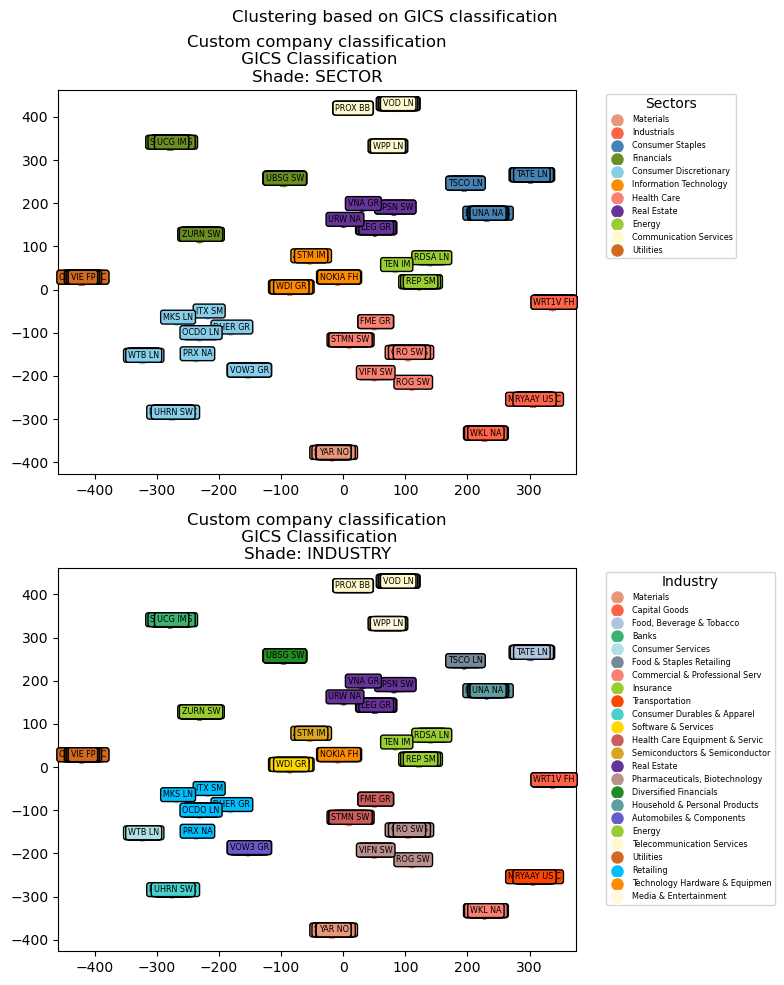

In [32]:
qn4 = pd.concat([qn3a_SectorName, qn3a_IndGrpName], axis=1) # ALL

# Run clustering based on analyst co-coverage only
cluster_4 = CustomCompanyClassification(qn4, qn3ref, name = "Custom company classification\n GICS Classification")
cluster_4.get_distance_matrix(metric = 'correlation')
cluster_4.perform_tSNE()

fig, axs = plt.subplots(2,1, figsize = (8,10))

fig.suptitle("Clustering based on GICS classification")

cluster_4.plot_cluster(ax = axs[0])
cluster_4.plot_cluster(ax = axs[1], shading='INDUSTRY')

sector_handles = [plt.Line2D([0], [0], marker='o', color='w', label=sector, markersize=10, markerfacecolor=color)
           for sector, color in sector_to_color.items()]
industry_handles = [plt.Line2D([0], [0], marker='o', color='w', label=industry, markersize=10, markerfacecolor=color)
           for industry, color in industry_to_color.items()]

axs[0].legend(title='Sectors', handles=sector_handles, bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 'xx-small')
axs[1].legend(title='Industry', handles=industry_handles, bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 'xx-small')

plt.tight_layout()
plt.show()

Based on the GICS Classification, `Consumer Discretionary` sector is the most heterogeneous. It includes 4 distinct industries, namely `Consumer Durables & Apparels`, `Automobiles and Components`, `Retailing` and `Consumer Services`.

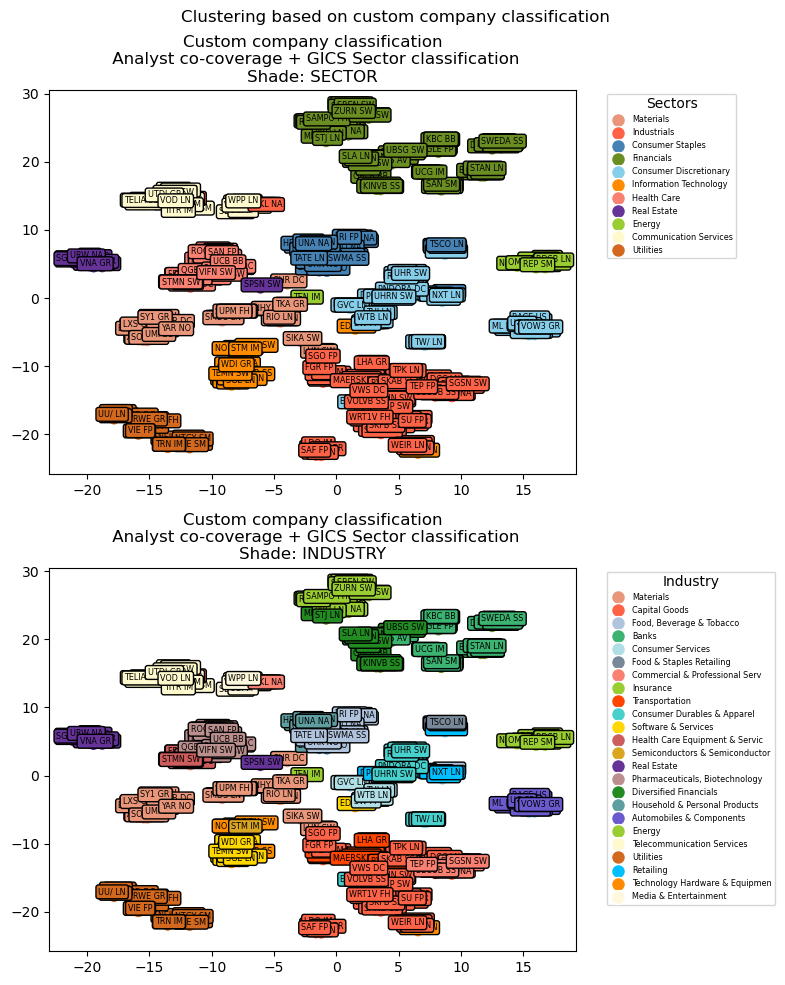

In [33]:
fig, axs = plt.subplots(2,1, figsize = (8,10))

fig.suptitle("Clustering based on custom company classification")

cluster_3c2.plot_cluster(ax = axs[0])
cluster_3c2.plot_cluster(ax = axs[1], shading='INDUSTRY')

sector_handles = [plt.Line2D([0], [0], marker='o', color='w', label=sector, markersize=10, markerfacecolor=color)
           for sector, color in sector_to_color.items()]
industry_handles = [plt.Line2D([0], [0], marker='o', color='w', label=industry, markersize=10, markerfacecolor=color)
           for industry, color in industry_to_color.items()]

axs[0].legend(title='Sectors', handles=sector_handles, bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 'xx-small')
axs[1].legend(title='Industry', handles=industry_handles, bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 'xx-small')

plt.tight_layout()
plt.show()

In [34]:
qn3ref['Custom Custer'] = cluster_3c2.cluster_labels
qn3ref.groupby(by = ['Custom Custer','GICS_SECTOR_NAME'])[['GICS_INDUSTRY_GROUP_NAME']].value_counts()

Custom Custer  GICS_SECTOR_NAME        GICS_INDUSTRY_GROUP_NAME      
0              Consumer Discretionary  Automobiles & Components          12
               Energy                  Energy                            10
1              Consumer Staples        Food, Beverage & Tobacco          17
                                       Household & Personal Products      7
               Energy                  Energy                             1
               Materials               Materials                          3
               Real Estate             Real Estate                        1
2              Consumer Discretionary  Consumer Durables & Apparel        1
               Industrials             Capital Goods                     39
                                       Commercial & Professional Serv    10
                                       Transportation                     1
               Information Technology  Technology Hardware & Equipmen     1
3              Fin

Based on our custom company classification scheme, the most heterogenous cluster is Cluster 4, which is made up of
- 4 unique sectors: `Consumer Discretionary`, `Industrials`, `Information Technology`,  `Materials` and
- 6 unique industries: `Consumer Services`, `Consumer Durables & Apparel`, `Transportation`, `Capital Goods`, `Software & Services`, `Materials`

Based on a visual inspection of the above plots of clusters, with the Industry labels and Sector labels overlaid respectively, we observe that the following sectors are more heterogeneous, covering across a few different industries as follows:
<br> (1) Industrials: covers Transportation / Capital Goods / Commercial & Professional Services
<br> (2) Healthcare Sector: covers Pharmaceuticals & Biotechnology / Healthcare Equipment & Services
<br> (3) Financials: covers Banks / Insurance / Diversified Financials
<br> (4) Consumer Staples: covers Food, Beverage & Tobacco / Household & Personal Products / Food & Staples Retailing
<br> (5) Consumer Discretionary: covers Retailing / Consumer Durables & Apparel / Consumer Services / Automobiles & Components
<br> (6) IT: covers Software & Services / Technology Hardware & Equipment / Semiconductors

Note that the custom company classification results shared some similarity, to limited extent, with the GICS classification done by Bloomberg as the highest-heterogenous sector from our custom algorithm contained Customer Discretionary. There are two common industries identified under the highest heterogenous sector which are `Consumer Durables & Apparels` and `Consumer Services`. This could mean that there is insights that we can learn from our custom classification and some credibiility as they showed similarity with BBG's model.

# 5. Similarly, which sectors are the most homogenous?

Based on a visual inspection of the above plots of clusters, with the Industry labels and Sector labels overlaid respectively, we observe that the following sectors are most homogenous:
<br> (1) Real Estate
<br> (2) Utilities
<br> (3) Materials
<br> (4) Energy

Based on our custom company classification scheme, cluster 0 - which represents the financial sector - is the most homogenous.

# 6. What type of companies tend to be outliers in terms of the clusters?


<br> (1) Companies that are classified as "Capital goods" tends to have more varied clustering classification regardless of clustering methods we choose. Possible fundamental reasons could be the broad/loose definition of `Capital Goods` and there are many sub-industries within capital goods which may have very different kind of business models. Hence there could be no common "Capital Goods" analysts covering them as whole.

<br> (2) Companies with different geography of operations from where its HQ is based could be an outlier, possibly. Alternatively, it could also be because such companies have more diversified businesses under its umbrella, while it is classified based on one of its primary business. For instance, for Real Estate, we observe a glaring outlier "SPSN SW" (Swiss Prime Site AG). "SPSN SW" has various Real Estate, Asset management, and Retail segments, making it stand out from other Real Estate firms that are purely in the real estate business.

# 7. Feel free to explore and provide deeper insights in the structure of the clusters/network as part of the outputs.

## Key summary

- Overall, the team explored various ways of building the custom company classification scheme, first by using analyst co-coverage only, and subsequently adding some additional features which we think will add information
- Of the additional features, `Brokerage` appears to be the less informative - adding `Brokerage` generally results in a worst-off situation, whereby we see deteriorating Silhouette scores
- GICS Industry and Sector classifications both add value to the clustering, results in a more defined cluster; However, this requires one to handle with care as we do not want to overweigh the GICS feature if the objective is to develop a pure alternative classification method. Here, we did a trade-off between uniqueness of the classification scheme for a more defined cluster, prioritizing quality
- Besides the Silhouette Score, we also looked at the Davies-Bouldin Index. The Davies-Bouldin Index is calculated as the average similarity between each cluster and its closest neighbor (similarity is defined as the ratio between inter-cluster and intra-cluster distances), where lower numbers are reflective of better clusters. Results are outlined above.

#### Observations
  
- An interesting observation among the clusters is that `Financials` and `Utitlies` clusters are far apart in the TSNE plot. As the distance between clusters is construed as similarity, long distance apart implies they are "dissimilar" sectors. This agrees with our economic intuition because we know that `Financials` has positive correlation with economy performance and `Utitlies` has negative correlation.